# MNIST Large Untrained Net CNN Exc Inh

Derived from https://www.kaggle.com/code/amyjang/tensorflow-mnist-cnn-tutorial/notebook

In [119]:
import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras import backend as K

print(tf.__version__)

2.8.2


In [120]:
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)

In [121]:
positiveWeightImplementation = False	#orig: True

preFinalDenseLayer = False

generateUntrainedNetwork = False
if(generateUntrainedNetwork):
    #only train the last layer
    numberOfHiddenLayers = 2    #default: 2    #if 0 then useSVM=True
else:
    numberOfHiddenLayers = 2   #default: 4

if(numberOfHiddenLayers > 1):
    addSkipLayers = False   #optional
else:
    addSkipLayers = False   #mandatory

layerSizeBase = 32  #default: 32

batch_size = 64 #default: 64
epochs = 5  #1  #5

debugPreTrainWeights = False
debugPreTrainOutputs = False
debugPostTrainWeights = False
debugPostTrainOutputs = False

## Load data

In [122]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [123]:
input_shape = (28, 28, 1)

x_train=x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_train=x_train / 255.0
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
x_test=x_test/255.0

In [124]:
y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
y_test = tf.one_hot(y_test.astype(np.int32), depth=10)

tf.Tensor([0. 0. 0. 0. 0. 1. 0. 0. 0. 0.], shape=(10,), dtype=float32)


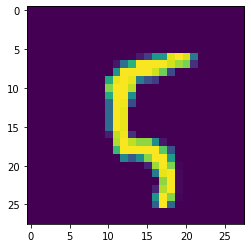

In [125]:
plt.imshow(x_train[100][:,:,0])
print(y_train[100])

## Define model

In [126]:
num_classes = 10

In [127]:
def activationExcitatory(x):
    return K.maximum(x, 0)  #ReLU

def activationInhibitory(x):
    if(positiveWeightImplementation):
        return -(K.maximum(x, 0))   #ReLU with negative output
    else:
        return K.maximum(x, 0)  #ReLU

def excitatoryNeuronInitializer(shape, dtype=None):
    return tf.math.abs(tf.random.normal(shape, dtype=dtype))

def inhibitoryNeuronInitializer(shape, dtype=None):
    if(positiveWeightImplementation):
        return tf.math.abs(tf.random.normal(shape, dtype=dtype))
    else:
        return tf.math.negative(tf.math.abs(tf.random.normal(shape, dtype=dtype)))

class negative(tf.keras.constraints.Constraint):
    #based on https://www.tensorflow.org/api_docs/python/tf/keras/constraints/Constraint
    def __init__(self):
        pass
    def __call__(self, w):
        return w * tf.cast(tf.math.less_equal(w, 0.), w.dtype)

In [128]:

if(positiveWeightImplementation):
    weightConstraint = tf.keras.constraints.non_neg()
    constrainBiases = True   #ensure positive biases also
    if(constrainBiases):
        biasConstraint = tf.keras.constraints.non_neg()
        constrainBiasesLastLayer = False
        if(constrainBiasesLastLayer):
            biasConstraintLastLayer = tf.keras.constraints.non_neg()
        else:
            biasConstraintLastLayer = None
    else:
        biasConstraint = None
        biasConstraintLastLayer = None
else:
    weightConstraintPositive = tf.keras.constraints.non_neg()
    weightConstraintNegative = negative()
    constrainBiases = False
    if(constrainBiases):
        biasConstraintPositive = tf.keras.constraints.non_neg()
        biasConstraintNegative = negative()
    else:
        biasConstraintPositive = None
        biasConstraintNegative = None

if(generateUntrainedNetwork):
    #only train the last layer
    generateLargeNetwork = True
else:
    generateLargeNetwork = False

if(generateLargeNetwork):
    largeNetworkRatio = 10    #100
    generateLargeNetworkExpansion = False
    if(generateLargeNetworkExpansion):
        generateLargeNetworkRatioExponential = False
else:
    generateLargeNetworkRatio = False

def getLayerRatio(layerIndex):
    layerRatio = 1
    if(generateLargeNetwork):
        if(generateLargeNetworkExpansion):
            if(generateLargeNetworkRatioExponential):
                layerRatio = largeNetworkRatio**layerIndex
            else:
                layerRatio = largeNetworkRatio * layerIndex
        else:
            layerRatio = largeNetworkRatio
    else:
        layerRatio = 1
    return int(layerRatio)

def createEIlayer(layerIndex, h0, firstLayer=False, maxpool2d=None, dropout=None):
    layerRatio = getLayerRatio(2)
    if(positiveWeightImplementation):
        h1E = tf.keras.layers.Conv2D(layerSizeBase*layerRatio, (5,5), kernel_initializer=excitatoryNeuronInitializer, kernel_constraint=weightConstraint, bias_constraint=biasConstraint, padding='same')(h0)
        h1I = tf.keras.layers.Conv2D(layerSizeBase*layerRatio, (5,5), kernel_initializer=inhibitoryNeuronInitializer, kernel_constraint=weightConstraint, bias_constraint=biasConstraint, padding='same')(h0)
        h1E = tf.keras.layers.Activation(activationExcitatory)(h1E)
        h1I = tf.keras.layers.Activation(activationInhibitory)(h1I)
        h1 = tf.keras.layers.Concatenate()([h1E, h1I])
        if(maxpool2d is not None):
            h1 = tf.keras.layers.MaxPool2D(strides=maxpool2d)(h1)
        if(dropout is not None):
            h1 = tf.keras.layers.Dropout(dropout)(h1)
    else:
        if(firstLayer):
            h1E = tf.keras.layers.Conv2D(layerSizeBase*layerRatio, (5,5), kernel_initializer=excitatoryNeuronInitializer, padding='same')(h0)
            h1I = tf.keras.layers.Conv2D(layerSizeBase*layerRatio, (5,5), kernel_initializer=inhibitoryNeuronInitializer, padding='same')(h0)
        else:
            h0E, h0I = h0
            h1Ee = tf.keras.layers.Conv2D(layerSizeBase*layerRatio, (5,5), kernel_initializer=excitatoryNeuronInitializer, kernel_constraint=weightConstraintPositive, bias_constraint=biasConstraintPositive, padding='same')(h0E) #excitatory neuron excitatory inputs
            h1Ei = tf.keras.layers.Conv2D(layerSizeBase*layerRatio, (5,5), kernel_initializer=excitatoryNeuronInitializer, kernel_constraint=weightConstraintNegative, bias_constraint=biasConstraintNegative, padding='same')(h0I) #excitatory neuron inhibitory inputs
            h1Ie = tf.keras.layers.Conv2D(layerSizeBase*layerRatio, (5,5), kernel_initializer=inhibitoryNeuronInitializer, kernel_constraint=weightConstraintPositive, bias_constraint=biasConstraintPositive, padding='same')(h0E) #inhibitory neuron excitatory inputs
            h1Ii = tf.keras.layers.Conv2D(layerSizeBase*layerRatio, (5,5), kernel_initializer=inhibitoryNeuronInitializer, kernel_constraint=weightConstraintNegative, bias_constraint=biasConstraintNegative, padding='same')(h0I) #inhibitory neuron inhibitory inputs
            h1E = tf.keras.layers.Add()([h1Ee, h1Ei])
            h1I = tf.keras.layers.Add()([h1Ie, h1Ii])
        h1E = tf.keras.layers.Activation(activationExcitatory)(h1E)
        h1I = tf.keras.layers.Activation(activationInhibitory)(h1I)
        if(maxpool2d is not None):
            h1E = tf.keras.layers.MaxPool2D(strides=maxpool2d)(h1E)
            h1I = tf.keras.layers.MaxPool2D(strides=maxpool2d)(h1I)
        if(dropout is not None):
            h1E = tf.keras.layers.Dropout(dropout)(h1E)
            h1I = tf.keras.layers.Dropout(dropout)(h1I)
        h1 = (h1E, h1I)
    return h1

def concatEIneurons(h):
    if(positiveWeightImplementation):
        return h
    else: 
        hE, hI = h
        h = tf.keras.layers.Concatenate()([hE, hI])
        return h

x = tf.keras.layers.Input(shape=input_shape)
h0 = x
hLast = h0
if(numberOfHiddenLayers >= 1):
    h1 = createEIlayer(1, h0, firstLayer=True)
    hLast = h1
if(numberOfHiddenLayers >= 2):
    h2 = createEIlayer(2, h1, maxpool2d=(1,1), dropout=0.25)
    hLast = h2
if(numberOfHiddenLayers >= 3):
    h3 = createEIlayer(3, h2)
    hLast = h3
if(numberOfHiddenLayers >= 4):
    h4 = createEIlayer(4, h3, maxpool2d=(2,2))
    hLast = h4
if(addSkipLayers):
    mList = []
    if(numberOfHiddenLayers >= 1):
        m1 = tf.keras.layers.Flatten()(concatEIneurons(h1))
        mList.append(m1)
    if(numberOfHiddenLayers >= 2):
        m2 = tf.keras.layers.Flatten()(concatEIneurons(h2))
        mList.append(m2)
    if(numberOfHiddenLayers >= 3):
        m3 = tf.keras.layers.Flatten()(concatEIneurons(h3))
        mList.append(m3)
    if(numberOfHiddenLayers >= 4):
        m4 = tf.keras.layers.Flatten()(concatEIneurons(h4))
        mList.append(m4)
    hLast = tf.keras.layers.concatenate(mList)
else:
    hLast = concatEIneurons(hLast)

hLast = tf.keras.layers.Flatten()(hLast)
if(preFinalDenseLayer):
    hLast = tf.keras.layers.Dense(128, activation='relu')(hLast)
    hLast = tf.keras.layers.Dropout(0.5)(hLast)
if(generateUntrainedNetwork):
    hLast = tf.keras.layers.Lambda(lambda x: tf.keras.backend.stop_gradient(x))(hLast)
y = tf.keras.layers.Dense(num_classes, activation='softmax')(hLast)
model = tf.keras.Model(x, y)

print(model.summary())

model.compile(optimizer=tf.keras.optimizers.RMSprop(epsilon=1e-08), loss='categorical_crossentropy', metrics=['acc'])


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_68 (Conv2D)             (None, 28, 28, 32)   832         ['input_9[0][0]']                
                                                                                                  
 conv2d_69 (Conv2D)             (None, 28, 28, 32)   832         ['input_9[0][0]']                
                                                                                                  
 activation_44 (Activation)     (None, 28, 28, 32)   0           ['conv2d_68[0][0]']              
                                                                                            

In [129]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.995):
      print("\nReached 99.5% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [130]:
if(debugPreTrainWeights):
    #testwritefile = open('weights.txt', 'a')
    for layerIndex, layer in enumerate(model.layers):
        heading = "layerWeights = " + str(layerIndex) + "\n"
        print(heading)
        #testwritefile.write(heading)
        weights = layer.get_weights()
        print(weights)
        #weightsS =  str(weights)
        #testwritefile.write(weightsS)

In [131]:
if(debugPreTrainOutputs):
    testwritefile = open('outputPreTrain.txt', 'a')
    xTrainFirstSample = np.expand_dims(x_train[0], axis=0)
    for layerIndex, layer in enumerate(model.layers):
        heading = "layerOutputs = " + str(layerIndex) + "\n"
        #print(heading)
        testwritefile.write(heading)
        func = K.function([model.get_layer(index=0).input], layer.output)
        layerOutput = func([xTrainFirstSample])  # input_data is a numpy array
        #print(layerOutput)
        layerOutputS =  str(layerOutput)
        testwritefile.write(layerOutputS)

## Train model

In [132]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.1,
                    callbacks=[callbacks])

Epoch 1/5
844/844 [==============================] - 556s 633ms/step - loss: 5640.6621 - acc: 0.7367 - val_loss: 352.7803 - val_acc: 0.8323
Epoch 2/5
844/844 [==============================] - 535s 634ms/step - loss: 100.4718 - acc: 0.8124 - val_loss: 2.6482 - val_acc: 0.8782
Epoch 3/5
844/844 [==============================] - 531s 629ms/step - loss: 0.5613 - acc: 0.9205 - val_loss: 0.1560 - val_acc: 0.9618
Epoch 4/5
844/844 [==============================] - 533s 631ms/step - loss: 0.1410 - acc: 0.9641 - val_loss: 0.1237 - val_acc: 0.9697
Epoch 5/5
844/844 [==============================] - 533s 631ms/step - loss: 0.0924 - acc: 0.9771 - val_loss: 0.1255 - val_acc: 0.9728


In [133]:
if(debugPostTrainWeights):
    #testwritefile = open('weights.txt', 'a')
    for layerIndex, layer in enumerate(model.layers):
        heading = "layerWeights = " + str(layerIndex) + "\n"
        print(heading)
        #testwritefile.write(heading)
        weights = layer.get_weights()
        print(weights)
        #weightsS =  str(weights)
        #testwritefile.write(weightsS)

In [134]:
if(debugPostTrainOutputs):
    testwritefile = open('outputPostTrain.txt', 'a')
    xTrainFirstSample = np.expand_dims(x_train[0], axis=0)
    for layerIndex, layer in enumerate(model.layers):
        heading = "layerOutputs = " + str(layerIndex) + "\n"
        #print(heading)
        testwritefile.write(heading)
        func = K.function([model.get_layer(index=0).input], layer.output)
        layerOutput = func([xTrainFirstSample])  # input_data is a numpy array
        #print(layerOutput)
        layerOutputS =  str(layerOutput)
        testwritefile.write(layerOutputS)

## Evaluate model

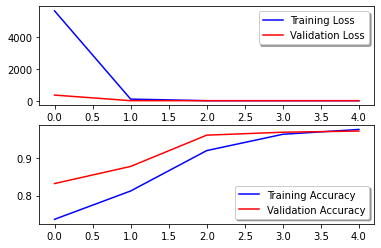

In [135]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training Loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation Loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training Accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [136]:
test_loss, test_acc = model.evaluate(x_test, y_test)

313/313 [==============================] - 21s 69ms/step - loss: 0.1435 - acc: 0.9676
